Plot nripples versus channel for all animals

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs, detect_ripple_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO
from neuropy.core.session import ProcessData
from neuropy.core.probe import Shank, Probe, ProbeGroup

from Psilocybin.subjects import get_psi_dir

# These are crucial parameters - otherwise all text gets output with each letter in a word or heading as a separate unit
# instead of a text box
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Specify Arial as font type - also crucial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Specify plotting parameters

In [31]:
animals = ["Finn", "Rey", "Rose", "Finn2"]
recordings = ["Saline1", "Psilocybin", "Saline2"]
chan_dict = {
    "Rey":   {"Saline1": 21, "Psilocybin": 21, "Saline2": 21},
    "Finn":  {"Saline1": 27, "Psilocybin": 27, "Saline2": 27},
    "Rose":  {"Saline1": 26, "Psilocybin": 26, "Saline2": 26},
    "Finn2": {"Saline1": 4,  "Psilocybin": 4,  "Saline2": 4}
}

chan_dict_nk = {
    "Rey":   {"Saline1": 21, "Psilocybin": 21, "Saline2": 22},
    "Finn":  {"Saline1": 27, "Psilocybin": 27, "Saline2": 27},
    "Rose":  {"Saline1": 27, "Psilocybin": 26, "Saline2": 25},
    "Finn2": {"Saline1": 4,  "Psilocybin": 4,  "Saline2": 4}
}

In [9]:
def load_artifact_epochs(diruse, animal_cap, recording_clean):
    artifact_csv = sorted(Path(diruse).glob("*.artifact.csv"))[0]
    if artifact_csv.exists():
        try:
            tmp = pd.read_csv(artifact_csv)
            start_col = next((c for c in tmp.columns if 'start' in c.lower()), None)
            stop_col  = next((c for c in tmp.columns if ('stop' in c.lower()) or ('end' in c.lower())), None)
            if start_col and stop_col:
                art_df = pd.DataFrame({
                    "start": pd.to_numeric(tmp[start_col], errors="coerce"),
                    "stop":  pd.to_numeric(tmp[stop_col],  errors="coerce"),
                    "label": "artifact"
                }).dropna()
                if not art_df.empty:
                    return Epoch(art_df)
        except Exception:  # NRK comment: In general you do NOT want to use any exception here because you can end
            # up catching bugs that you might not have anticipated. You want to use a specific type of error here,
            # e.g. 'FileNotFoundError' if you are worried about missing a file, or 'TypeError' if you are worried that
            # some files are not being imported to the correct data type
            pass
    else:
        print(f"{str(artifact_csv)} file not found")
    return None

In [26]:
ripple_epochs, rpl_power = detect_ripple_epochs(
                full_signal, sess.prbgrp,
                thresh=(4, None),
                ripple_channel=int(chan),
                ignore_epochs=art_epochs,
                mindur=0.05,
                return_power=True
            )

Selected channels for ripples: [31]
310 epochs remaining with durations within (0.05,0.45)


In [38]:
pd.DataFrame({"animal": animal, "recording": recording, "channel": chan,
              "nrpl": ripple_epochs.n_epochs,
              "mean_peak_power": ripple_epochs.to_dataframe().peak_power_abs.mean()},
             index=[0])


,animal,recording,channel,nrpl,mean_peak_power
0,Finn2,Saline2,31,310,284.478699


In [ ]:
nrpl_dict = {"Finn":{"Saline1":[], "Psilocybin":[], "Saline2":[]}, 
             "Rey":{"Saline1":[], "Psilocybin":[], "Saline2":[]}, 
             "Rose":{"Saline1":[], "Psilocybin":[], "Saline2":[]}, 
             "Finn2":{"Saline1":[], "Psilocybin":[], "Saline2":[]}}
chan_stats_df = []
for animal in animals:
    animal_cap = animal.capitalize()
    for recording in recordings:
        print(f"Running {animal} {recording}") # NRK debugging add
        # diruse = os.path.join(BASE_DIR_ROOT, animal, recording)
        diruse = get_psi_dir(animal, recording) # NRK compatibility add
        if not os.path.isdir(diruse):
            continue

        sess = ProcessData(diruse)

        try:
            full_signal = sess.eegfile.get_signal()
        except Exception:
            print("Error in line 106") # NRK debug add
            continue

        recording_clean = recording.replace("_", "")
        injection_file = sorted(sess.basepath.glob("*.injection.npy"))[0]
        if not injection_file.exists():
            print("injection file missing") # NRK debug add
            continue

        inj_obj = np.load(injection_file, allow_pickle=True).item()
        post_idx = next((k for k, v in inj_obj['epochs']['label'].items() if v == "POST"), None)
        if post_idx is None:
            print("No POST epochs detected.")
            continue
        inj_time = float(inj_obj['epochs']['start'][post_idx])
        print(f"Injection time = {inj_time}")

        # Bug here - combined with lines below this was choosing the wrong channel to calculate peak frequency and power.
        # Importantly the correct channel was being used for initial ripple detection though...
        # chan_ids = np.arange(32, 0, -1)
        # shank = Shank().auto_generate(columns=1, contacts_per_column=32, channel_id=chan_ids)

        # NRK bugfix for the above is on the next two lines.
        chan_ids = np.arange(0, 32, 1)
        shank = Shank().auto_generate(columns=1, contacts_per_column=32, xpitch=0, ypitch=-50, channel_id=chan_ids)
        shank.set_disconnected_channels(sess.recinfo.skipped_channels) # NRK be sure to keep this in.
        sess.prbgrp = ProbeGroup()
        sess.prbgrp.add_probe(Probe(shank))

        
        art_epochs = load_artifact_epochs(diruse, animal_cap, recording_clean)
        for chan in sess.recinfo.good_channels:
            ripple_epochs, rpl_power = detect_ripple_epochs(
                full_signal, sess.prbgrp,
                thresh=(4, None),
                ripple_channel=int(chan),
                ignore_epochs=art_epochs,
                mindur=0.05,
                return_power=True
            )
            
            nrpl_dict[animal][recording].append([chan, ripple_epochs.n_epochs,
                                                ripple_epochs.to_dataframe().peak_power_abs.mean()])
            stats_df = pd.DataFrame({"animal": animal, "recording": recording, "channel": chan,
                                     "nrpl": ripple_epochs.n_epochs,
                                     "mean_peak_power": ripple_epochs.to_dataframe().peak_power_abs.mean()},
                                     index=[0])
            chan_stats_df.append(stats_df)
chan_stats_df = pd.concat(chan_stats_df, axis=0, ignore_index=True)

Running Finn Saline1
Injection time = 0.0
Selected channels for ripples: [0]
120 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [1]
102 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [3]
138 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [4]
102 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [5]
127 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [7]
173 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [8]
155 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [9]
135 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [10]
148 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [11]
132 epochs remaining with durations within (0.05,0.45)
Selected channels for ripples: [12]
159 epochs remaining

In [24]:
pyr_chan = chan_dict[animal][recording]
idpyr = np.where(nrpl_array[:, 0] == pyr_chan)[0][0]
idpyr

3

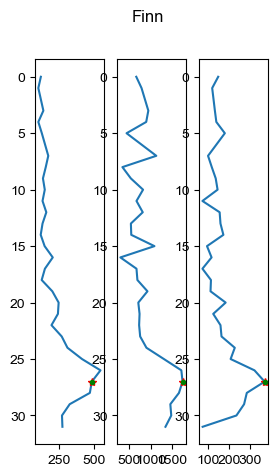

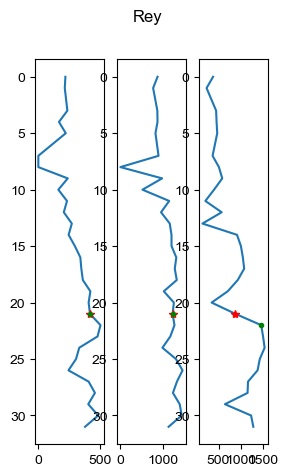

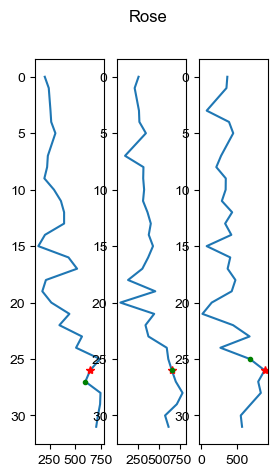

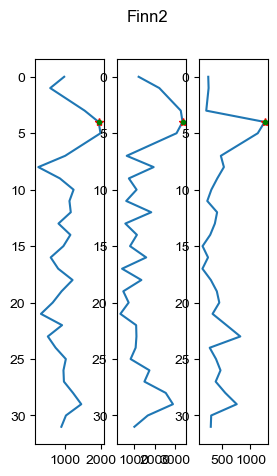

In [32]:
from neuropy.utils.plot_util import match_axis_lims
for animal in animals:
    animal_cap = animal.capitalize()
    fig, ax = plt.subplots(1, 3, figsize=(3, 5))
    fig.suptitle(animal)
    for idr, recording in enumerate(recordings):
        nrpl_array = np.array(nrpl_dict[animal][recording])
        ax[idr].plot(nrpl_array[:, 1], nrpl_array[:, 0])
        ax[idr].invert_yaxis()

        pyr_chan = chan_dict[animal][recording]
        idpyr = np.where(nrpl_array[:, 0] == pyr_chan)[0][0]
        ax[idr].plot(nrpl_array[idpyr, 1], nrpl_array[idpyr, 0], 'r*')

        pyr_chan = chan_dict_nk[animal][recording]
        idpyr = np.where(nrpl_array[:, 0] == pyr_chan)[0][0]
        ax[idr].plot(nrpl_array[idpyr, 1], nrpl_array[idpyr, 0], 'g.')

    # match_axis_lims(ax, "x")
        

In [20]:
nrpl_array[:, 0] == 3

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
ripple_thresh = 4 # 2.5 or 4

# Cut down Finn2 saline to 1hr?
chop_finn2_saline = False  # True = only use 1st hour of Finn2 saline, False = use all
finn2_append = "_1hrsalineonly" if chop_finn2_saline else ""

# ... OR only use 1hr Psilocybin for all
limit_to_1st_hr = False
chop_all_append = "_allsessions1hr" if limit_to_1st_hr else ""
finn2_append = "" if chop_all_append else finn2_append

## Load in data

In [ ]:
df_grp = []
for ida, animal in enumerate(animals):
    file_use = get_psi_dir(animal, "Saline1").parent / "aggdata" / f"{animal.lower()}_rpl_features_thresh{'_'.join(str(ripple_thresh).split('.'))}{chop_all_append}.csv"
    df_animal = pd.read_csv(file_use, index_col=0)
    df_animal["Animal_name"] = animal
    df_animal["Animal"] = ida + 1
    df_grp.append(df_animal)

df_grp = pd.concat(df_grp, axis=0, ignore_index=True)
df_grp
    

In [ ]:
# Get mean values for each metric
df_grp["session"] = pd.Categorical(df_grp["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean = df_grp.groupby(["Animal_name", "session"]).mean(numeric_only=True)
df_mean

In [ ]:
# Get ripple counts as well
df_count = df_grp.loc[:, ["session", "Animal_name", "start"]].groupby(["Animal_name", "session"]).count()
df_count.rename(columns={"start": "rpl_count"})

In [ ]:
df_clip = df_grp[(df_grp.start < 3600) & (df_grp.start > 0)]
df_clip

In [ ]:
# Compare to Ilknur data after bugfix
ilknur_new_df = pd.read_csv("/data3/Psilocybin/Recording_Rats/ripple_features_group_from_final_plots.csv", index_col=0)
ilknur_new_df

In [ ]:
# Compare to Ilknur data (old)
ilknur_df = pd.read_csv("/Users/nkinsky/Documents/UM/Working/Psilocybin/Recording_Rats/SWR_all_animals_group_data.csv")
ilknur_mean = ilknur_df.groupby(["Animal_name", "session"]).mean(numeric_only=True)
ilknur_mean

In [ ]:
ilknur_m

## Plotting template here with appropriate size graphics and parameters

In [ ]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
titles = ["Duration (s)", "Peak Power", "Peak Frequency", "SW Amplitude"]
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
for idf, feature in enumerate(features):
    ax = axs.reshape(-1)[idf]
    plot_legend = True if idf == 0 else False
    sns.boxplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", showfliers=False, fill=False, 
                legend=plot_legend, ax=ax)
    sns.stripplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", size=2, 
                  linewidth=0.1, edgecolor="w", alpha=0.3, rasterized=rasterize_scatter,
                  legend=False, ax=ax)
    ax.set_ylabel(titles[idf])
    sns.despine(ax=ax)

fig.savefig(plot_dir / "ripple_features.pdf", dpi=600)

## Other investigations / experimental plots below

### Investigate Rose Psilocybin session - why are peak frequency and power off by so much?!?

In [ ]:
df_rose = df_grp[df_grp.Animal == "Rose"]
df_rose_psi = df_rose[df_rose.session == "Psilocybin"]
_, ax = plt.subplots()
ax.plot(df_rose_psi.peak_time, df_rose_psi.peak_power)

In [ ]:
_, ax = plt.subplots()
sns.lineplot(data=df_mean, x="session", y="duration", hue="Animal", ax=ax)

In [ ]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    # sns.violinplot(data=df_grp, x="session", y=feature, cut=0.1, inner="quart", ax=a)
    sns.boxplot(data=df_grp, x="session", y=feature, showfliers=False, ax=a)
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)
    # sal1_df = df_grp[df_grp.session == "Saline 1"]
    # psi_df = df_grp[df_grp.session == "Psilocybin"]
    # sal2_df = df_grp[df_grp.session == "Saline 2"]

    # sal1_v_psi = stats.mannwhitneyu(sal1_df[feature].values, psi_df[feature].values)
    # psi_v_sal2 = stats.mannwhitneyu(psi_df[feature].values, sal2_df[feature].values)
    # sal1_v_sal2 = stats.mannwhitneyu(sal1_df[feature].values, sal2_df[feature].values)

    print(f"FEATURE: {feature}")
    for grps_use in [["Saline 1", "Psilocybin"], ["Psilocybin", "Saline 2"], ["Saline 1", "Saline 2"]]:
        grp1_vals = df_grp[df_grp.session == grps_use[0]][feature].values
        grp2_vals = df_grp[df_grp.session == grps_use[1]][feature].values
        print(f"{grps_use[0]} mean = {np.mean(grp1_vals)}, {grps_use[1]} mean = {np.mean(grp2_vals)}")
        mannu_stats = stats.mannwhitneyu(grp1_vals, grp2_vals)
        print(f"Mann-Whitney U test p-value={mannu_stats.pvalue}\n")
    print("\n")

_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)

In [ ]:
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]

In [ ]:
_, ax = plt.subplots()
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]
sns.violinplot(data=df_split, y="duration", hue="session", split=True, ax=ax)

In [ ]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.boxenplot(data=df_grp, x="session", y=feature, ax=a)